In [ ]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [55]:
pwd

'/content/EVA8/Session_5_Assignment/EVA8/Session_5_Assignment'

In [57]:
%cd ..


/content/EVA8/Session_5_Assignment


In [53]:
!git clone https://github.com/shreyash-99/EVA8.git

Cloning into 'EVA8'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 161 (delta 70), reused 58 (delta 22), pack-reused 0
Receiving objects: 100% (161/161), 2.48 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [54]:
%cd EVA8/Session_5_Assignment

/content/EVA8/Session_5_Assignment/EVA8/Session_5_Assignment


In [58]:
from model import get_model

In [59]:
train_transforms = transforms.Compose([transforms.RandomRotation((-7.0,7.0), fill = (1,)) ,  
                                      transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081, ))])
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

In [60]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available" , cuda)

#for Reproducibilty
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# setting the dataloader arguments for both test and train data
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

train_loader = torch.utils.data.DataLoader(train , **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA available True


In [61]:
!ls

Assignment-5_sample.ipynb  data  EVA8  model.py  __pycache__


In [62]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_GN = get_model("GN").to(device)
model_LN = get_model("LN").to(device)
model_BN = get_model("BN").to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [63]:
summary(model_GN, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 26, 26]           1,152
       BatchNorm2d-6           [-1, 16, 26, 26]              32
              ReLU-7           [-1, 16, 26, 26]               0
           Dropout-8           [-1, 16, 26, 26]               0
            Conv2d-9            [-1, 8, 26, 26]             128
        MaxPool2d-10            [-1, 8, 13, 13]               0
           Conv2d-11           [-1, 16, 11, 11]           1,152
      BatchNorm2d-12           [-1, 16, 11, 11]              32
             ReLU-13           [-1, 16, 11, 11]               0
          Dropout-14           [-1, 16,

In [64]:
summary(model_LN, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         LayerNorm-3            [-1, 8, 26, 26]          10,816
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 26, 26]           1,152
              ReLU-6           [-1, 16, 26, 26]               0
         LayerNorm-7           [-1, 16, 26, 26]          21,632
           Dropout-8           [-1, 16, 26, 26]               0
            Conv2d-9            [-1, 8, 26, 26]             128
        MaxPool2d-10            [-1, 8, 13, 13]               0
           Conv2d-11           [-1, 16, 11, 11]           1,152
             ReLU-12           [-1, 16, 11, 11]               0
        LayerNorm-13           [-1, 16, 11, 11]           3,872
          Dropout-14           [-1, 16,

In [65]:
summary(model_BN, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 26, 26]           1,152
       BatchNorm2d-6           [-1, 16, 26, 26]              32
              ReLU-7           [-1, 16, 26, 26]               0
           Dropout-8           [-1, 16, 26, 26]               0
            Conv2d-9            [-1, 8, 26, 26]             128
        MaxPool2d-10            [-1, 8, 13, 13]               0
           Conv2d-11           [-1, 16, 11, 11]           1,152
      BatchNorm2d-12           [-1, 16, 11, 11]              32
             ReLU-13           [-1, 16, 11, 11]               0
          Dropout-14           [-1, 16,

In [84]:
from tqdm import tqdm


def train(model, device, train_loader, optimiser, epoch, L1_regularisation = "false"):

  train_losses = []
  train_acc = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    #get samples
    data, target = data.to(device), target.to(device)

    #init
    optimiser.zero_grad()

    #prediction
    y_pred = model(data)

    #calculate loss
    loss = F.nll_loss(y_pred, target)
    if L1_regularisation.lower() == "true":
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      lambda_l1 = loss / (l1 * 10)         # keeping lambda for 10 % loss in weights
      loss = loss + lambda_l1 * l1

    train_losses.append(loss)

    #Backpropagation
    loss.backward()
    optimiser.step()

    # update pbar - tqdm

    pred = y_pred.argmax(dim = 1, keepdim = True) # gets the index of the max log-probabilirty
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  return train_losses, train_acc

def test(model, device, test_loader):
  test_losses = []
  test_acc = []
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
  test_acc.append(100. * correct / len(test_loader.dataset))
  return test_losses, test_acc


def plot_missclassification(model,test_loader):
  model.eval()
  misclassified_images = []    
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, pred = torch.max(output, 1)
      for i in range(len(pred)):
        if pred[i] != target[i]:
          misclassified_images.append({'image': data[i], 'predicted_class': pred[i], 'correct_class': target[i]})
  return misclassified_images

In [85]:
from torch.optim.lr_scheduler import StepLR

model =  model_GN.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
GN_test_losses = []
GN_test_accuracies = []

EPOCHS = 20
for epoch in range(EPOCHS):
  print("EPOCH:", epoch, "Learning Rate: ", scheduler.get_last_lr())
  GN_train_loss, GN_train_acc = train(model, device, train_loader, optimizer, epoch)
  scheduler.step()
  GN_test_loss, GN_test_acc = test(model, device, test_loader)
  GN_test_losses.append(GN_test_loss[0])
  GN_test_accuracies.append(GN_test_acc[0])

EPOCH: 0 Learning Rate:  [0.03]


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.0372132770717144 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]



Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)

EPOCH: 1 Learning Rate:  [0.03]


Loss=0.0818607434630394 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]



Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 2 Learning Rate:  [0.03]


Loss=0.0329187847673893 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]



Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 3 Learning Rate:  [0.03]


Loss=0.05594624578952789 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]



Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99.10%)

EPOCH: 4 Learning Rate:  [0.03]


Loss=0.1392487734556198 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 5 Learning Rate:  [0.03]


Loss=0.022972991690039635 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]



Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 6 Learning Rate:  [0.003]


Loss=0.006387756671756506 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]



Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 7 Learning Rate:  [0.003]


Loss=0.04874219372868538 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]



Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 8 Learning Rate:  [0.003]


Loss=0.03073340654373169 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]



Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 9 Learning Rate:  [0.003]


Loss=0.02111879177391529 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 21.32it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 10 Learning Rate:  [0.003]


Loss=0.054240062832832336 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]



Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 11 Learning Rate:  [0.003]


Loss=0.035656679421663284 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]



Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 12 Learning Rate:  [0.00030000000000000003]


Loss=0.01847524754703045 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 13 Learning Rate:  [0.00030000000000000003]


Loss=0.005480107385665178 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

EPOCH: 14 Learning Rate:  [0.00030000000000000003]


Loss=0.0019207908771932125 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]



Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 15 Learning Rate:  [0.00030000000000000003]


Loss=0.010391868650913239 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]



Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 16 Learning Rate:  [0.00030000000000000003]


Loss=0.0063828472048044205 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 17 Learning Rate:  [0.00030000000000000003]


Loss=0.005814763251692057 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s]



Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 18 Learning Rate:  [3.0000000000000004e-05]


Loss=0.003115219296887517 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]



Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

EPOCH: 19 Learning Rate:  [3.0000000000000004e-05]


Loss=0.02370852418243885 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]



Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)



In [86]:
GN_test_accuracies

[99.24,
 99.34,
 99.4,
 99.1,
 99.29,
 99.23,
 99.38,
 99.41,
 99.39,
 99.43,
 99.41,
 99.4,
 99.39,
 99.42,
 99.41,
 99.4,
 99.43,
 99.42,
 99.43,
 99.42]

<class 'list'>


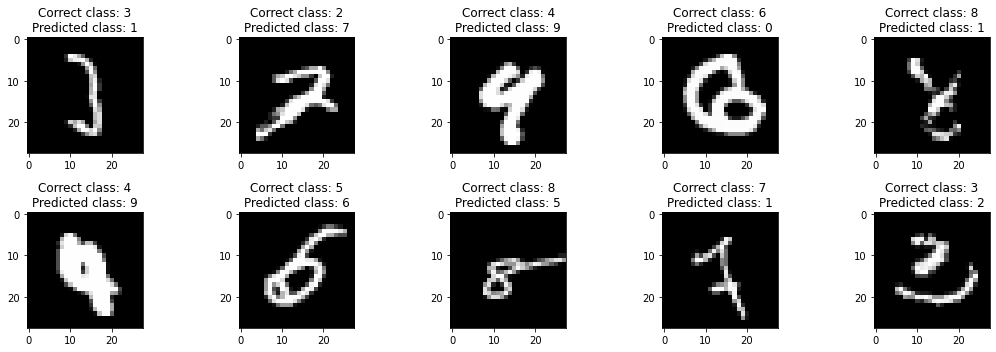

In [87]:
import matplotlib.pyplot as plt
misclassified_images_GN = plot_missclassification(model, test_loader)
print(type(misclassified_images_GN))
fig = plt.figure(figsize=(15, 5))
for i in range(10):
  sub = fig.add_subplot(2, 5, i+1)
  misclassified_image = misclassified_images_GN[i]
  plt.imshow(misclassified_image['image'].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
  sub.set_title("Correct class: {}\nPredicted class: {}".format(misclassified_image['correct_class'], misclassified_image['predicted_class']))
plt.tight_layout()
plt.show()

In [88]:
from torch.optim.lr_scheduler import StepLR

model =  model_LN.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
LN_test_losses = []
LN_test_accuracies = []

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch, "Learning Rate: ", scheduler.get_last_lr())
    LN_train_loss, LN_train_acc = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    LN_test_loss, LN_test_acc = test(model, device, test_loader)
    LN_test_losses.append(LN_test_loss[0])
    LN_test_accuracies.append(LN_test_acc[0])

EPOCH: 0 Learning Rate:  [0.03]


Loss=0.03598655387759209 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]



Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)

EPOCH: 1 Learning Rate:  [0.03]


Loss=0.05677634850144386 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]



Test set: Average loss: 0.0261, Accuracy: 9922/10000 (99.22%)

EPOCH: 2 Learning Rate:  [0.03]


Loss=0.007201609667390585 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]



Test set: Average loss: 0.0212, Accuracy: 9940/10000 (99.40%)

EPOCH: 3 Learning Rate:  [0.03]


Loss=0.014906872995197773 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]



Test set: Average loss: 0.0287, Accuracy: 9906/10000 (99.06%)

EPOCH: 4 Learning Rate:  [0.03]


Loss=0.0684015229344368 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]



Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 5 Learning Rate:  [0.03]


Loss=0.035998813807964325 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]



Test set: Average loss: 0.0215, Accuracy: 9941/10000 (99.41%)

EPOCH: 6 Learning Rate:  [0.003]


Loss=0.0092848502099514 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]



Test set: Average loss: 0.0164, Accuracy: 9952/10000 (99.52%)

EPOCH: 7 Learning Rate:  [0.003]


Loss=0.011058167554438114 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]



Test set: Average loss: 0.0163, Accuracy: 9952/10000 (99.52%)

EPOCH: 8 Learning Rate:  [0.003]


Loss=0.03414362296462059 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]



Test set: Average loss: 0.0161, Accuracy: 9952/10000 (99.52%)

EPOCH: 9 Learning Rate:  [0.003]


Loss=0.025441596284508705 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]



Test set: Average loss: 0.0164, Accuracy: 9951/10000 (99.51%)

EPOCH: 10 Learning Rate:  [0.003]


Loss=0.02149462141096592 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]



Test set: Average loss: 0.0158, Accuracy: 9955/10000 (99.55%)

EPOCH: 11 Learning Rate:  [0.003]


Loss=0.025922344997525215 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]



Test set: Average loss: 0.0158, Accuracy: 9956/10000 (99.56%)

EPOCH: 12 Learning Rate:  [0.00030000000000000003]


Loss=0.015548422932624817 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]



Test set: Average loss: 0.0154, Accuracy: 9956/10000 (99.56%)

EPOCH: 13 Learning Rate:  [0.00030000000000000003]


Loss=0.013566765002906322 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]



Test set: Average loss: 0.0155, Accuracy: 9956/10000 (99.56%)

EPOCH: 14 Learning Rate:  [0.00030000000000000003]


Loss=0.010657884180545807 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:21<00:00, 21.33it/s]



Test set: Average loss: 0.0155, Accuracy: 9956/10000 (99.56%)

EPOCH: 15 Learning Rate:  [0.00030000000000000003]


Loss=0.04188929498195648 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]



Test set: Average loss: 0.0154, Accuracy: 9956/10000 (99.56%)

EPOCH: 16 Learning Rate:  [0.00030000000000000003]


Loss=0.010283811017870903 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]



Test set: Average loss: 0.0153, Accuracy: 9954/10000 (99.54%)

EPOCH: 17 Learning Rate:  [0.00030000000000000003]


Loss=0.009974823333323002 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]



Test set: Average loss: 0.0154, Accuracy: 9953/10000 (99.53%)

EPOCH: 18 Learning Rate:  [3.0000000000000004e-05]


Loss=0.0014141428982838988 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]



Test set: Average loss: 0.0154, Accuracy: 9953/10000 (99.53%)

EPOCH: 19 Learning Rate:  [3.0000000000000004e-05]


Loss=0.006583646405488253 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]



Test set: Average loss: 0.0154, Accuracy: 9953/10000 (99.53%)



<class 'list'>


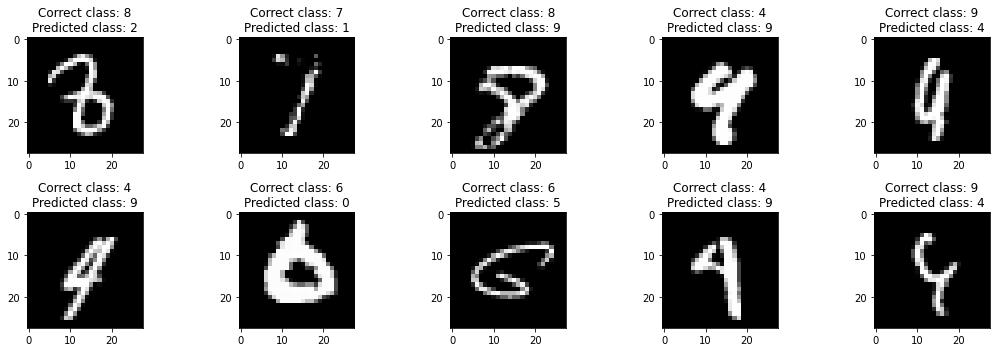

In [89]:
import matplotlib.pyplot as plt
misclassified_images_LN = plot_missclassification(model, test_loader)
print(type(misclassified_images_LN))
fig = plt.figure(figsize=(15, 5))
for i in range(10):
  sub = fig.add_subplot(2, 5, i+1)
  misclassified_image = misclassified_images_LN[i]
  plt.imshow(misclassified_image['image'].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
  sub.set_title("Correct class: {}\nPredicted class: {}".format(misclassified_image['correct_class'], misclassified_image['predicted_class']))
plt.tight_layout()
plt.show()

In [90]:
from torch.optim.lr_scheduler import StepLR

model =  model_BN.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
BN_test_losses = []
BN_test_accuracies = []

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch, "Learning Rate: ", scheduler.get_last_lr())
    BN_train_loss, BN_train_acc = train(model, device, train_loader, optimizer, epoch, "true")
    scheduler.step()
    BN_test_loss, BN_test_acc = test(model, device, test_loader)
    BN_test_losses.append(BN_test_loss[0])
    BN_test_accuracies.append(BN_test_acc[0])

EPOCH: 0 Learning Rate:  [0.03]


Loss=0.012565161101520061 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]



Test set: Average loss: 0.0233, Accuracy: 9931/10000 (99.31%)

EPOCH: 1 Learning Rate:  [0.03]


Loss=0.06284476071596146 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]



Test set: Average loss: 0.0305, Accuracy: 9901/10000 (99.01%)

EPOCH: 2 Learning Rate:  [0.03]


Loss=0.05931258574128151 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s]



Test set: Average loss: 0.0228, Accuracy: 9920/10000 (99.20%)

EPOCH: 3 Learning Rate:  [0.03]


Loss=0.026264680549502373 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:23<00:00, 19.86it/s]



Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.30%)

EPOCH: 4 Learning Rate:  [0.03]


Loss=0.023410314694046974 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]



Test set: Average loss: 0.0238, Accuracy: 9916/10000 (99.16%)

EPOCH: 5 Learning Rate:  [0.03]


Loss=0.00954023003578186 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:23<00:00, 19.95it/s]



Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH: 6 Learning Rate:  [0.003]


Loss=0.0069345831871032715 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:23<00:00, 19.83it/s]



Test set: Average loss: 0.0171, Accuracy: 9941/10000 (99.41%)

EPOCH: 7 Learning Rate:  [0.003]


Loss=0.024353766813874245 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.0165, Accuracy: 9943/10000 (99.43%)

EPOCH: 8 Learning Rate:  [0.003]


Loss=0.0018447641050443053 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s]



Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 9 Learning Rate:  [0.003]


Loss=0.008117351680994034 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:23<00:00, 20.08it/s]



Test set: Average loss: 0.0164, Accuracy: 9942/10000 (99.42%)

EPOCH: 10 Learning Rate:  [0.003]


Loss=0.04997572302818298 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0160, Accuracy: 9942/10000 (99.42%)

EPOCH: 11 Learning Rate:  [0.003]


Loss=0.013226166367530823 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]



Test set: Average loss: 0.0162, Accuracy: 9940/10000 (99.40%)

EPOCH: 12 Learning Rate:  [0.00030000000000000003]


Loss=0.11235647648572922 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:22<00:00, 20.39it/s]



Test set: Average loss: 0.0162, Accuracy: 9942/10000 (99.42%)

EPOCH: 13 Learning Rate:  [0.00030000000000000003]


Loss=0.02004920318722725 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s]



Test set: Average loss: 0.0160, Accuracy: 9940/10000 (99.40%)

EPOCH: 14 Learning Rate:  [0.00030000000000000003]


Loss=0.08686868101358414 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s]



Test set: Average loss: 0.0161, Accuracy: 9943/10000 (99.43%)

EPOCH: 15 Learning Rate:  [0.00030000000000000003]


Loss=0.01431128941476345 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s]



Test set: Average loss: 0.0163, Accuracy: 9941/10000 (99.41%)

EPOCH: 16 Learning Rate:  [0.00030000000000000003]


Loss=0.019992610439658165 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]



Test set: Average loss: 0.0164, Accuracy: 9941/10000 (99.41%)

EPOCH: 17 Learning Rate:  [0.00030000000000000003]


Loss=0.04330362379550934 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]



Test set: Average loss: 0.0163, Accuracy: 9944/10000 (99.44%)

EPOCH: 18 Learning Rate:  [3.0000000000000004e-05]


Loss=0.037338756024837494 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]



Test set: Average loss: 0.0158, Accuracy: 9943/10000 (99.43%)

EPOCH: 19 Learning Rate:  [3.0000000000000004e-05]


Loss=0.06413234770298004 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]



Test set: Average loss: 0.0168, Accuracy: 9940/10000 (99.40%)



<class 'list'>


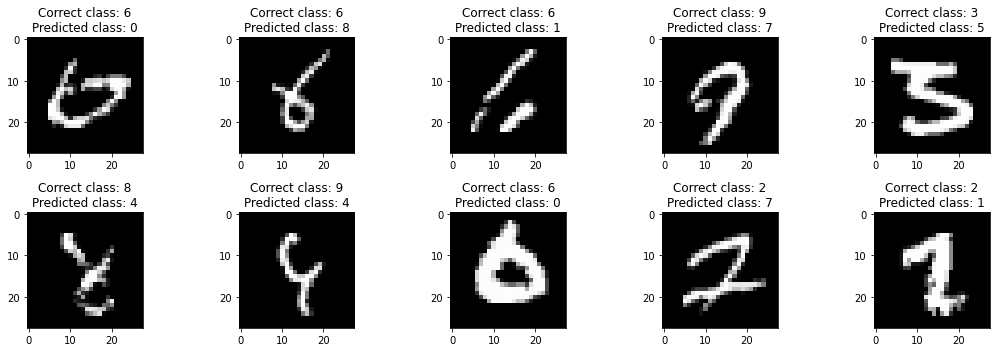

In [91]:
import matplotlib.pyplot as plt
misclassified_images_BN = plot_missclassification(model, test_loader)
print(type(misclassified_images_LN))
fig = plt.figure(figsize=(15, 5))
for i in range(10):
  sub = fig.add_subplot(2, 5, i+1)
  misclassified_image = misclassified_images_BN[i]
  plt.imshow(misclassified_image['image'].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
  sub.set_title("Correct class: {}\nPredicted class: {}".format(misclassified_image['correct_class'], misclassified_image['predicted_class']))
plt.tight_layout()
plt.show()

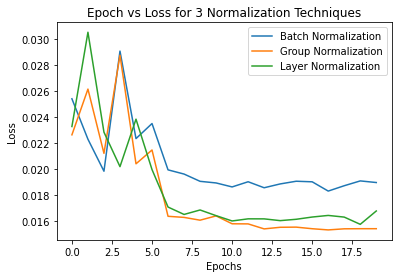

In [95]:
plt.plot(GN_test_losses, label="Batch Normalization")
plt.plot(LN_test_losses, label="Group Normalization")
plt.plot(BN_test_losses, label="Layer Normalization")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Epoch vs Loss for 3 Normalization Techniques")
plt.legend()

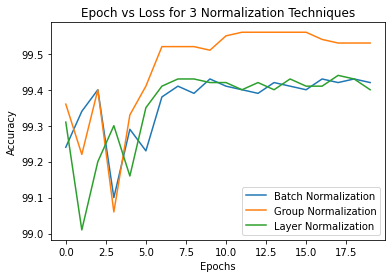

In [96]:
plt.plot(GN_test_accuracies, label="Batch Normalization")
plt.plot(LN_test_accuracies, label="Group Normalization")
plt.plot(BN_test_accuracies, label="Layer Normalization")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Epoch vs Loss for 3 Normalization Techniques")
plt.legend()

In [94]:
BN_test_acc

[99.4]